<a href="https://colab.research.google.com/github/ethngo7/pytorchfire/blob/main/calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Install pytorchfire and dependencies

%pip install pytorchfire
%pip install requests
%pip install matplotlib
%pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [2]:
!nvidia-smi

Sun Aug 10 00:16:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# @title Download the dataset

from google.colab import files
import requests

# @markdown If you want to upload your own data, set `upload_custom_data` to `True` and make sure to upload all the files listed in `file_list`.
# @markdown The format should be either `.npy` or `.npz`.
# @markdown If you want to use the demo dataset, set `upload_custom_data` to `False`.
upload_custom_data = False # @param {type:"boolean"}

file_list = [
    'initial_ignition',
    'p_den',
    'p_veg',
    'slope',
    'target',
    'wind_towards_direction',
    'wind_velocity',
    'target',
]

def download_file(url, filename):
    response = requests.get(url, stream=True)
    response.raise_for_status()

    with open(filename, 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)

if upload_custom_data:
    uploaded = files.upload()

    for fn in uploaded.keys():
      print('User uploaded file "{name}" with length {length} bytes'.format(
          name=fn, length=len(uploaded[fn])))
else:
    remote_map_name = 'Bear_2020'

    for file in file_list:
        file_url = f'https://github.com/xiazeyu/PyTorchFire/raw/refs/heads/main/examples/{remote_map_name}/{file}.npz'
        filename = f'{file}.npz'
        download_file(file_url, filename)

        print(f"File downloaded and saved as {filename}")


File downloaded and saved as initial_ignition.npz
File downloaded and saved as p_den.npz
File downloaded and saved as p_veg.npz
File downloaded and saved as slope.npz
File downloaded and saved as target.npz
File downloaded and saved as wind_towards_direction.npz
File downloaded and saved as wind_velocity.npz
File downloaded and saved as target.npz


In [4]:
# @title Load the dataset
import numpy as np
import os

def load_np_file(file_name):

    if os.path.exists(f'{file_name}.npy'):
        return np.load(f'{file_name}.npy')
    elif os.path.exists(f'{file_name}.npz'):
        ds = np.load(f'{file_name}.npz')
        if len(ds.files) == 1:
            return ds[ds.files[0]]
        else:
            raise ValueError(f"Multiple arrays found in {file_name}. Please provide a single array.")

p_veg = load_np_file('p_veg')
p_den = load_np_file('p_den')
wind_towards_direction = load_np_file('wind_towards_direction')
wind_velocity = load_np_file('wind_velocity')
slope = load_np_file('slope')
initial_ignition = load_np_file('initial_ignition')
target = load_np_file('target')

a = 0.13324953615665436 # @param {type:"number"}
c_1 = 0.11270108073949814 # @param {type:"number"}
c_2 = 0.15624772012233734 # @param {type:"number"}
max_steps = 50 # @param {type:"integer"}
p_continue = 0.2814338207244873 # @param {type:"slider", min:0, max:1, step:0.05}
p_h = 0.3236876130104065 # @param {type:"slider", min:0, max:1, step:0.05}
wind_step_interval = 15 # @param {type:"integer"}


In [5]:
# @title Custom, Random Ignition

import numpy as np
import matplotlib.pyplot as plt

# 🔘 Toggle: set to True to use custom blob-style ignition
use_custom_ignition = False # @param {type:"boolean"}

# ✅ Function to create clustered ignition pattern (blobs)
def create_ignition_blobs(shape, num_blobs=5, blob_radius=4, seed=None):
    np.random.seed(seed)
    ignition = np.zeros(shape, dtype=np.uint8)
    H, W = shape

    for _ in range(num_blobs):
        center_h = np.random.randint(blob_radius, H - blob_radius)
        center_w = np.random.randint(blob_radius, W - blob_radius)

        ignition[
            center_h - blob_radius:center_h + blob_radius,
            center_w - blob_radius:center_w + blob_radius
        ] = 1

    return ignition

# 🔄 Choose ignition source
if use_custom_ignition:
    initial_ignition = create_ignition_blobs(shape=(128, 128), num_blobs=5, blob_radius=4, seed=42)
    print("🔥 Using custom ignition (blobs)")
else:
    initial_ignition = load_np_file("initial_ignition")
    print("✅ Using original ignition (dataset)")


✅ Using original ignition (dataset)


/tmp/ipython-input-2980537443.py:8: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


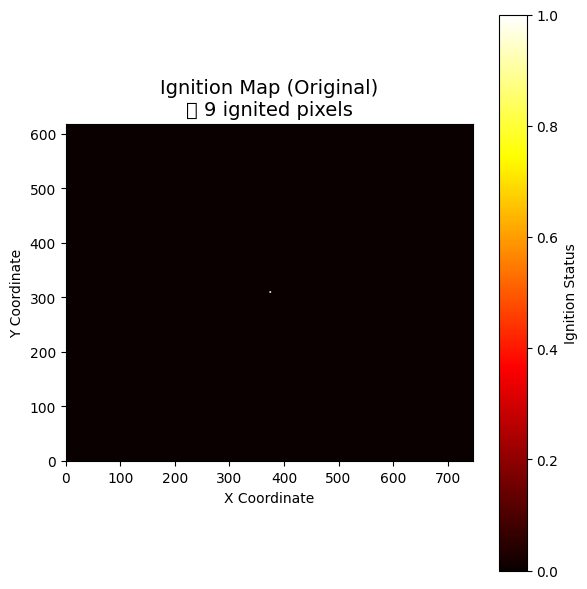

In [6]:
plt.figure(figsize=(6, 6))
plt.imshow(initial_ignition, cmap="hot", origin="lower", vmin=0, vmax=1)
plt.title(f"Ignition Map ({'Custom Blobs' if use_custom_ignition else 'Original'})\n🔥 {np.sum(initial_ignition)} ignited pixels", fontsize=14)
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.colorbar(label="Ignition Status")
plt.grid(False)
plt.tight_layout()
plt.show()


In [7]:
# @title Define Trainer class (similar to DataLoader)

from pytorchfire import WildfireModel, BaseTrainer
from tqdm import tqdm
import torch

class DemoTrainer(BaseTrainer):
    def train(self):

        self.reset()
        self.model.to(self.device)
        self.model.train()

        max_iterations = self.max_steps // self.steps_update_interval

        postfix = {}
        with tqdm() as progress_bar:
            for epochs in range(self.max_epochs):
                postfix['epoch'] = f'{epochs + 1}/{self.max_epochs}'
                self.model.reset()
                batch_seed = self.model.seed

                for iterations in range(max_iterations):
                    postfix['iteration'] = f'{iterations + 1}/{max_iterations}'
                    iter_max_steps = min(self.max_steps, (iterations + 1) * self.steps_update_interval)
                    progress_bar.reset(total=iter_max_steps)

                    for steps in range(iter_max_steps):
                        postfix['step'] = f'{steps + 1}/{iter_max_steps}'

                        if steps % wind_step_interval == 0:
                            self.model.wind_towards_direction = torch.tensor(
                                wind_towards_direction[steps // wind_step_interval], device=self.device)
                            self.model.wind_velocity = torch.tensor(wind_velocity[steps // wind_step_interval],
                                                                    device=self.device)

                        self.model.compute(attach=self.check_if_attach(steps, iter_max_steps))

                        progress_bar.set_postfix(postfix)
                        progress_bar.update(1)

                    outputs = self.model.accumulator
                    targets = target[iter_max_steps - 1]
                    targets = torch.tensor(targets, device=self.device)

                    loss = self.criterion(outputs, targets)
                    postfix['loss'] = f'{loss.item():.4f}'

                    self.backward(loss)
                    self.model.reset(seed=batch_seed)

    def evaluate(self):

        self.reset()
        self.model.to(self.device)
        self.model.eval()

        affected_cell_count_outputs = []
        affected_cell_count_targets = []

        postfix = {}
        output_list = []

        with tqdm(total=self.max_steps) as progress_bar:
                with torch.no_grad():
                    for steps in range(self.max_steps):
                        postfix['steps'] = f'{steps + 1}/{self.max_steps}'

                        if steps % wind_step_interval == 0:
                            self.model.wind_towards_direction = torch.tensor(
                                wind_towards_direction[steps // wind_step_interval], device=device)
                            self.model.wind_velocity = torch.tensor(wind_velocity[steps // wind_step_interval],
                                                                    device=device)

                        self.model.compute()
                        outputs = self.model.state[0] | self.model.state[1]

                        postfix['burning'] = self.model.state[0].sum().detach().cpu().item()
                        postfix['burned'] = self.model.state[1].sum().detach().cpu().item()

                        output_list.append(outputs.cpu().detach().numpy())

                        progress_bar.set_postfix(postfix)
                        progress_bar.update(1)

        return output_list

In [8]:
# @title Define trainer

from pytorchfire import WildfireModel, BaseTrainer
from tqdm import tqdm
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {device}")

trainer = DemoTrainer(model=WildfireModel({
            'p_veg': torch.tensor(p_veg),
            'p_den': torch.tensor(p_den),
            'wind_towards_direction': torch.tensor(wind_towards_direction[0]),
            'wind_velocity': torch.tensor(wind_velocity[0]),
            'slope': torch.tensor(slope),
            'initial_ignition': torch.tensor(initial_ignition, dtype=torch.bool)
        }, {
            'a': torch.tensor(.0),
            'p_h': torch.tensor(.15),
            'p_continue': torch.tensor(.3),
            'c_1': torch.tensor(.0),
            'c_2': torch.tensor(.0),
        }), device=torch.device(device))

trainer.max_epochs = 5
trainer.steps_update_interval = 10
trainer.max_steps = max_steps
trainer.lr = 0.005
trainer.seed = None


Using device: cuda


100%|██████████| 50/50 [00:02<00:00, 23.36it/s, steps=50/50, burning=110, burned=1607]


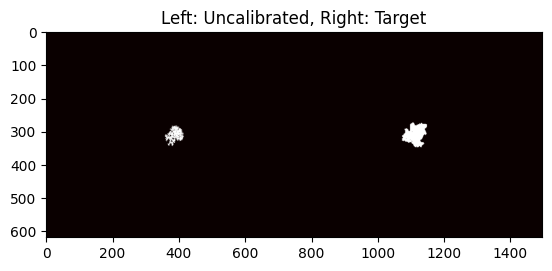

In [9]:
# @title Visualize the simulation (before calibration)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# generate uncalibrated simulation
after_calibration = np.array(trainer.evaluate())
ground_truth = target[:max_steps]

combined = np.concatenate((np.array(after_calibration), ground_truth), axis=2)

fig, ax = plt.subplots()

im = ax.imshow(combined[0], cmap='hot')
ax.set_title('Left: Uncalibrated, Right: Target')

def update(frame):
    im.set_array(combined[frame])
    return [im]

ani = FuncAnimation(
    fig, update, frames=len(combined), interval=100, blit=True
)

ani.save('calibration_before.gif', fps=10)
HTML(ani.to_jshtml())

![Animation](https://github.com/xiazeyu/PyTorchFire/blob/main/examples/calibration_before.gif?raw=1)

In [10]:
# @title Evaluation Metrics (before Calibration)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

# BEFORE CALIBRATION
gt = (ground_truth > 0.5).astype(int).reshape(-1)
pred_before = (after_calibration > 0.5).astype(int).reshape(-1)

# ⬇️ Store in separate variables
accuracy_b = accuracy_score(gt, pred_before)
precision_b = precision_score(gt, pred_before, zero_division=0)
recall_b = recall_score(gt, pred_before, zero_division=0)
f1_b = f1_score(gt, pred_before, zero_division=0)
iou_b = jaccard_score(gt, pred_before, zero_division=0)
temp_err_b = np.mean(np.abs(np.argmax(after_calibration, axis=0) - np.argmax(ground_truth, axis=0)))

metrics_before_vals = {
    "Accuracy": accuracy_b,
    "Precision": precision_b,
    "Recall": recall_b,
    "F1 Score": f1_b,
    "IoU": iou_b,
    "Temporal Error": temp_err_b
}

metrics_before_vals

{'Accuracy': 0.9973377363869619,
 'Precision': 0.6776527882570821,
 'Recall': 0.2744572388982262,
 'F1 Score': 0.39068323595416754,
 'IoU': np.float64(0.2427634165519953),
 'Temporal Error': np.float64(0.25491995887795565)}

In [11]:
# @title Perform parameter calibration
trainer.train()

100%|██████████| 50/50 [00:04<00:00, 11.68it/s, epoch=5/5, iteration=5/5, step=50/50, loss=0.7306]


100%|██████████| 50/50 [00:00<00:00, 56.40it/s, steps=50/50, burning=204, burned=4480]


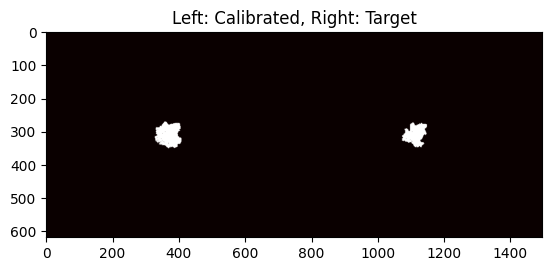

In [12]:
# @title Visualize the simulation (after calibration)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# generate calibrated simulation
after_calibration = np.array(trainer.evaluate())
ground_truth = target[:max_steps]

combined = np.concatenate((np.array(after_calibration), ground_truth), axis=2)

fig, ax = plt.subplots()

im = ax.imshow(combined[0], cmap='hot')
ax.set_title('Left: Calibrated, Right: Target')

def update(frame):
    im.set_array(combined[frame])
    return [im]

ani = FuncAnimation(
    fig, update, frames=len(combined), interval=100, blit=True
)

ani.save('calibration_after.gif', fps=10)
HTML(ani.to_jshtml())

![Animation](https://github.com/xiazeyu/PyTorchFire/blob/main/examples/calibration_after.gif?raw=1)

In [13]:
# @title Which Direction is Spreading the Most?

def directional_fire_spread_map(fire_map):
    """
    Computes how many pixels are burning in North, South, East, and West.
    fire_map: 2D numpy array (single timestep fire map)
    Returns: dictionary with counts for N, S, E, W
    """
    H, W = fire_map.shape
    center_h, center_w = H // 2, W // 2

    # Binarize the fire map
    fire_bin = (fire_map > 0.5).astype(int)

    counts = {
        'North': np.sum(fire_bin[:center_h, :]),
        'South': np.sum(fire_bin[center_h:, :]),
        'West':  np.sum(fire_bin[:, :center_w]),
        'East':  np.sum(fire_bin[:, center_w:])
    }

    return counts


North: 2096 burning pixels
South: 2588 burning pixels
West: 2605 burning pixels
East: 2079 burning pixels


/tmp/ipython-input-1436118770.py:19: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


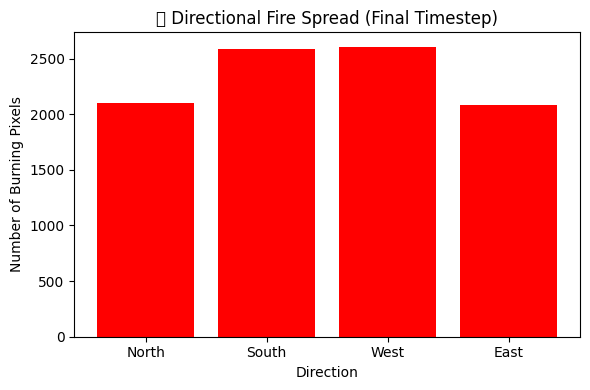

In [14]:
# @title Raw Count

# Get the last timestep's fire map
final_fire_map = after_calibration[-1]

# Compute directional spread
direction_counts = directional_fire_spread_map(final_fire_map)

# Print results
for direction, count in direction_counts.items():
    print(f"{direction}: {count} burning pixels")

# Visualize
plt.figure(figsize=(6, 4))
plt.bar(direction_counts.keys(), direction_counts.values(), color='red')
plt.title("🔥 Directional Fire Spread (Final Timestep)")
plt.ylabel("Number of Burning Pixels")
plt.xlabel("Direction")
plt.tight_layout()
plt.show()


/tmp/ipython-input-3610096972.py:14: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


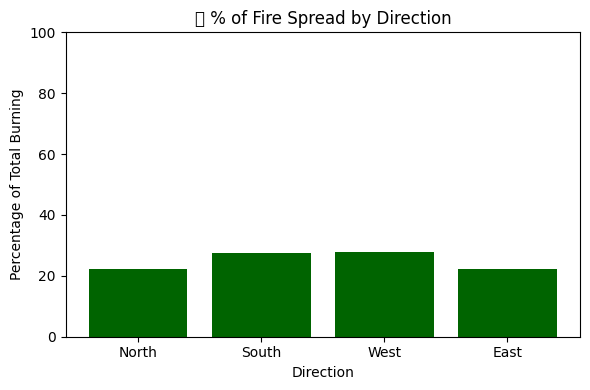

In [15]:
# @title Normalized Count (%)

# 🔄 Normalize to percent of total fire
total_burning = sum(direction_counts.values())
percentages = {k: (v / total_burning * 100) for k, v in direction_counts.items()}

# 📊 Bar chart of percentage spread
plt.figure(figsize=(6, 4))
plt.bar(percentages.keys(), percentages.values(), color='darkgreen')
plt.title("🔥 % of Fire Spread by Direction")
plt.ylabel("Percentage of Total Burning")
plt.xlabel("Direction")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


/tmp/ipython-input-3529573676.py:20: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


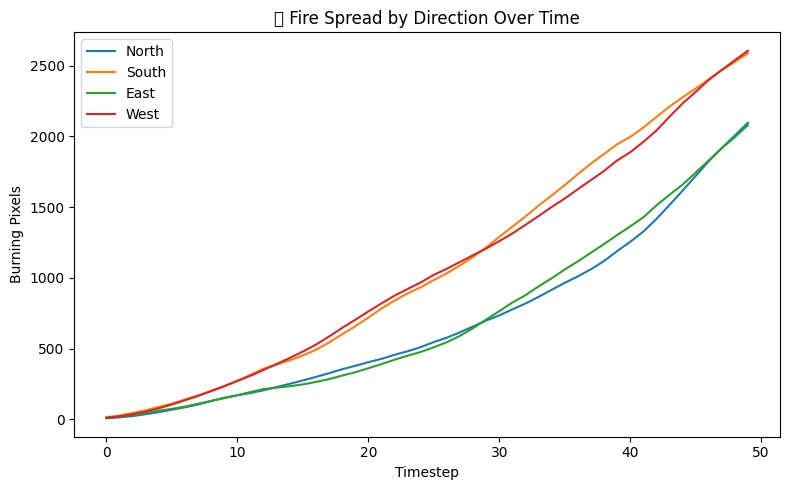

In [16]:
# Fire Spread by Direction Over Time

# 🔁 Analyze spread over all timesteps
timesteps = after_calibration.shape[0]
direction_history = {'North': [], 'South': [], 'East': [], 'West': []}

for t in range(timesteps):
    counts = directional_fire_spread_map(after_calibration[t])
    for dir in direction_history:
        direction_history[dir].append(counts[dir])

# 📈 Line plot of spread per direction over time
plt.figure(figsize=(8, 5))
for dir in direction_history:
    plt.plot(direction_history[dir], label=dir)
plt.title("🔥 Fire Spread by Direction Over Time")
plt.xlabel("Timestep")
plt.ylabel("Burning Pixels")
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipython-input-3332666971.py:74: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3332666971.py:74: UserWarning: Glyph 127788 (\N{WIND BLOWING FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3332666971.py:74: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3332666971.py:74: UserWarning: Glyph 9968 (\N{MOUNTAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127788 (\N{WIND BLOWING FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarnin

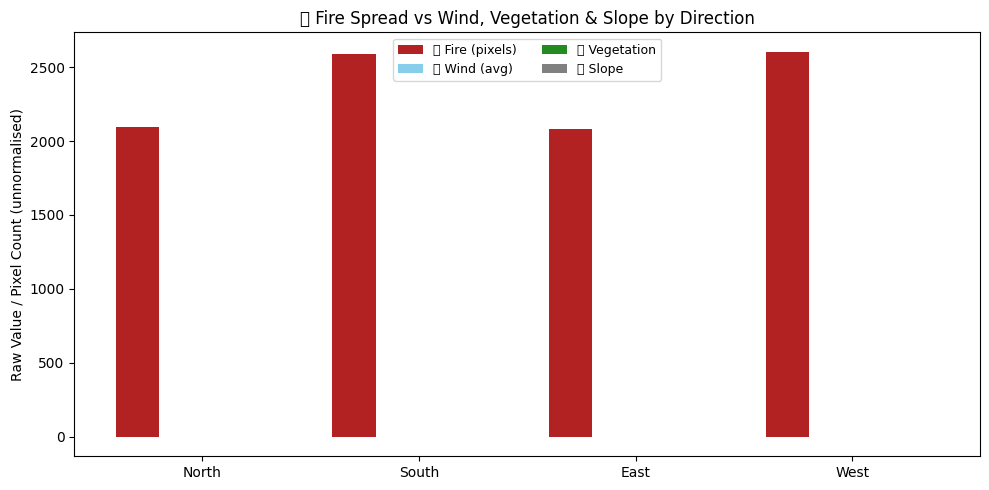

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# ────────────────────────────────────────────────────────────
# Helper 1 – fire pixels per direction (assumes 2-D binary map)
def directional_fire_spread_map(fire_map_2d):
    H, W = fire_map_2d.shape
    ch, cw = H // 2, W // 2
    fire_bin = (fire_map_2d > 0.5).astype(int)
    return {
        'North': fire_bin[:ch, :].sum(),
        'South': fire_bin[ch:, :].sum(),
        'West':  fire_bin[:, :cw].sum(),
        'East':  fire_bin[:, cw:].sum()
    }

# ────────────────────────────────────────────────────────────
# Helper 2 – quadrant averages for arrays shaped (..., H, W)
def quadrant_averages(arr):
    arr = np.asarray(arr)

    # collapse every axis except the last two (H, W)
    if arr.ndim > 2:
        collapse_axes = tuple(range(arr.ndim - 2))
        arr2d = arr.mean(axis=collapse_axes)
    else:
        arr2d = arr

    arr2d = np.squeeze(arr2d)   # remove singleton dims
    if arr2d.ndim != 2:
        raise ValueError(f"Expected 2-D after collapsing; got {arr2d.shape}")

    H, W = arr2d.shape
    ch, cw = H // 2, W // 2
    return {
        'North': arr2d[:ch, :].mean(),
        'South': arr2d[ch:, :].mean(),
        'West':  arr2d[:, :cw].mean(),
        'East':  arr2d[:, cw:].mean()
    }

# ────────────────────────────────────────────────────────────
# 1) Fire spread counts (final timestep of simulation)
final_fire_map = after_calibration[-1]            # shape (H, W)
fire_counts = directional_fire_spread_map(final_fire_map)

# 2) Environmental averages per quadrant
wind_avg   = quadrant_averages(wind_velocity)     # accepts (T, H, W) or (H, W)
veg_avg    = quadrant_averages(p_veg)
slope_avg  = quadrant_averages(slope)

# ────────────────────────────────────────────────────────────
# 3) Grouped bar plot
directions = ['North', 'South', 'East', 'West']
x = np.arange(len(directions))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(x - 1.5*width, [fire_counts[d] for d in directions],
       width, label='🔥 Fire (pixels)',   color='firebrick')
ax.bar(x - 0.5*width, [wind_avg[d]   for d in directions],
       width, label='🌬️ Wind (avg)',     color='skyblue')
ax.bar(x + 0.5*width, [veg_avg[d]    for d in directions],
       width, label='🌱 Vegetation',      color='forestgreen')
ax.bar(x + 1.5*width, [slope_avg[d]  for d in directions],
       width, label='⛰️ Slope',          color='gray')

ax.set_xticks(x)
ax.set_xticklabels(directions)
ax.set_title("🔥 Fire Spread vs Wind, Vegetation & Slope by Direction")
ax.set_ylabel("Raw Value / Pixel Count (unnormalised)")
ax.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()


/tmp/ipython-input-3054927036.py:76: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3054927036.py:76: UserWarning: Glyph 127788 (\N{WIND BLOWING FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3054927036.py:76: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3054927036.py:76: UserWarning: Glyph 9968 (\N{MOUNTAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127788 (\N{WIND BLOWING FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarnin

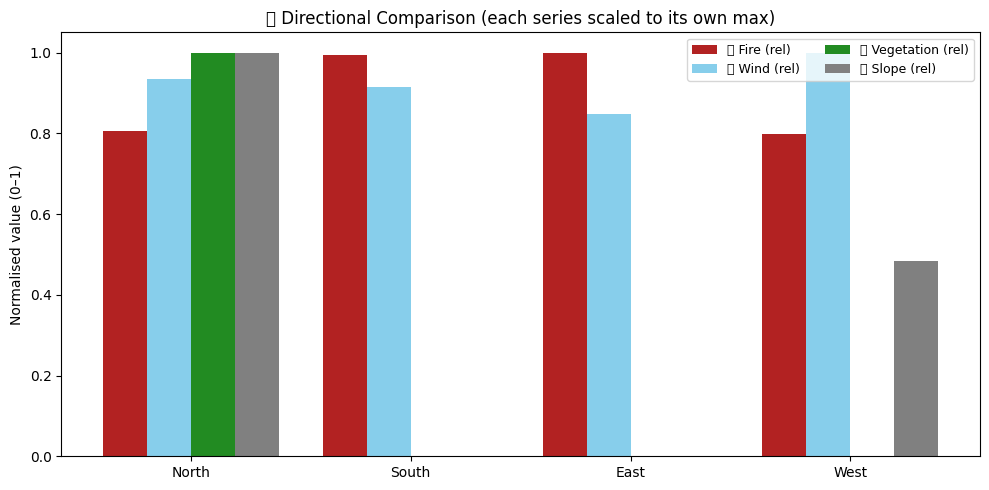

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# ───────────────────────────
# Helper 1 – burning pixels N/S/E/W
def directional_fire_spread_map(fire_map_2d):
    H, W = fire_map_2d.shape
    ch, cw = H // 2, W // 2
    fire_bin = (fire_map_2d > 0.5).astype(int)
    return {
        'North': fire_bin[:ch, :].sum(),
        'South': fire_bin[ch:, :].sum(),
        'West':  fire_bin[:, :cw].sum(),
        'East':  fire_bin[:, cw:].sum()
    }

# Helper 2 – quadrant averages for arrays shaped (..., H, W)
def quadrant_averages(arr):
    arr = np.asarray(arr)
    if arr.ndim > 2:                      # collapse leading dims (time/channel)
        arr2d = arr.mean(axis=tuple(range(arr.ndim - 2)))
    else:
        arr2d = arr
    arr2d = np.squeeze(arr2d)
    if arr2d.ndim != 2:
        raise ValueError(f"Expected 2-D after squeeze, got {arr2d.shape}")

    H, W = arr2d.shape
    ch, cw = H // 2, W // 2
    return {
        'North': arr2d[:ch, :].mean(),
        'South': arr2d[ch:, :].mean(),
        'West':  arr2d[:, :cw].mean(),
        'East':  arr2d[:, cw:].mean()
    }

# ───────────────────────────
# 1) Fire counts (final frame)
final_fire = after_calibration[-1]
fire_counts = directional_fire_spread_map(final_fire)

# 2) Env averages
wind_avg   = quadrant_averages(wind_velocity)
veg_avg    = quadrant_averages(p_veg)
slope_avg  = quadrant_averages(slope)

# ───────────────────────────
# 3) Build normalised series (0–1 each set)
def _norm(d):
    m = max(d.values())
    return [v / m if m else 0 for v in d.values()]

directions = ['North', 'South', 'East', 'West']
fire_norm  = _norm(fire_counts)
wind_norm  = _norm(wind_avg)
veg_norm   = _norm(veg_avg)
slope_norm = _norm(slope_avg)

# ───────────────────────────
# 4) Plot
x = np.arange(len(directions))
width = 0.2

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(x - 1.5*width, fire_norm,  width, color='firebrick',    label='🔥 Fire (rel)')
ax.bar(x - 0.5*width, wind_norm,  width, color='skyblue',     label='🌬️ Wind (rel)')
ax.bar(x + 0.5*width, veg_norm,   width, color='forestgreen', label='🌱 Vegetation (rel)')
ax.bar(x + 1.5*width, slope_norm, width, color='gray',        label='⛰️ Slope (rel)')

ax.set_xticks(x)
ax.set_xticklabels(directions)
ax.set_ylim(0, 1.05)
ax.set_ylabel("Normalised value (0–1)")
ax.set_title("🔥 Directional Comparison (each series scaled to its own max)")
ax.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()


In [19]:
# if slope is a large factor, I assume that it the slope is rising in the direction of the spread

In [20]:
def get_wind_slice(t):
    if wind_velocity.ndim == 3:
        return wind_velocity[t % wind_velocity.shape[0]]
    else:
        return wind_velocity


/tmp/ipython-input-401342716.py:36: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-401342716.py:36: UserWarning: Glyph 127788 (\N{WIND BLOWING FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


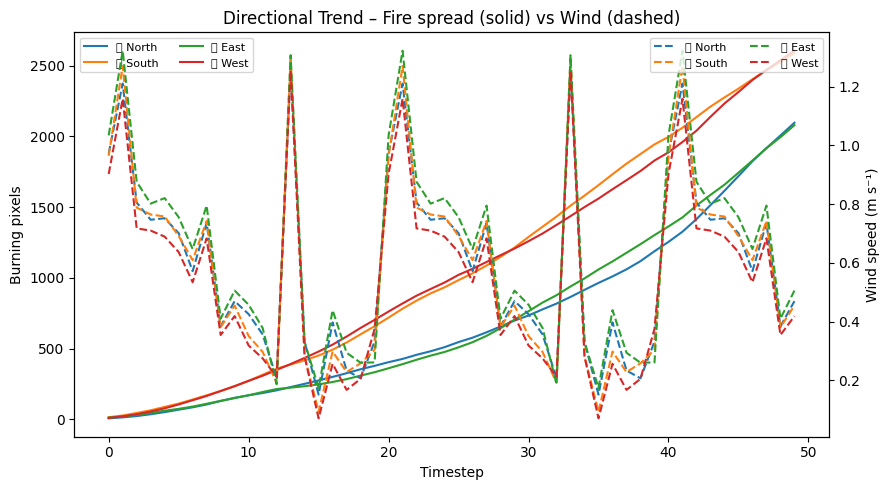

In [21]:
# ─────────────────────────────
# 1) Collect spread & wind over all timesteps
T = after_calibration.shape[0]
dirs = ['North', 'South', 'East', 'West']

fire_ts   = {d: [] for d in dirs}
wind_ts   = {d: [] for d in dirs}

for t in range(T):
    # fire counts
    counts = directional_fire_spread_map(after_calibration[t])
    for d in dirs:
        fire_ts[d].append(counts[d])

    # wind: if 3-D use frame t, else static
    wind_slice = get_wind_slice(t)
    wavg = quadrant_averages(wind_slice)
    for d in dirs:
        wind_ts[d].append(wavg[d])

# ─────────────────────────────
# 2) Plot fire & wind trends
fig, ax1 = plt.subplots(figsize=(9,5))
ax2 = ax1.twinx()

for d in dirs:
    ax1.plot(fire_ts[d],  label=f"🔥 {d}")
    ax2.plot(wind_ts[d],  '--',  label=f"🌬️ {d}")

ax1.set_title("Directional Trend – Fire spread (solid) vs Wind (dashed)")
ax1.set_xlabel("Timestep")
ax1.set_ylabel("Burning pixels")
ax2.set_ylabel("Wind speed (m s⁻¹)")
ax1.legend(ncol=2, fontsize=8, loc='upper left')
ax2.legend(ncol=2, fontsize=8, loc='upper right')
plt.tight_layout()
plt.show()


In [23]:
import pandas as pd
from scipy.stats import pearsonr

records = []

for t in range(T):
    fire_cnt = directional_fire_spread_map(after_calibration[t])
    wind_slice = get_wind_slice(t)
    wavg = quadrant_averages(wind_slice)
    vegavg  = quadrant_averages(p_veg)
    slopeavg= quadrant_averages(slope)

    for d in dirs:
        records.append({
            "dir": d,
            "time": t,
            "fire":  fire_cnt[d],
            "wind":  wavg[d],
            "veg":   vegavg[d],
            "slope": slopeavg[d]
        })

df = pd.DataFrame(records)

def corr(x, y):
    r, p = pearsonr(x, y)
    return f"{r:.2f} (p={p:.3g})"

print("Pearson correlation across all directions & timesteps:")
print("Fire vs Wind : ", corr(df['fire'], df['wind']))
print("Fire vs Veg  : ", corr(df['fire'], df['veg']))
print("Fire vs Slope: ", corr(df['fire'], df['slope']))

# Optional: per-direction correlations
print("\nPer-direction correlations:")
for d in dirs:
    sub = df[df.dir==d]
    print(f"{d:5s}  fire-wind: {corr(sub.fire, sub.wind)} | "
          f"fire-veg: {corr(sub.fire, sub.veg)} | "
          f"fire-slope: {corr(sub.fire, sub.slope)}")


Pearson correlation across all directions & timesteps:
Fire vs Wind :  -0.06 (p=0.39)
Fire vs Veg  :  -0.18 (p=0.0117)
Fire vs Slope:  -0.23 (p=0.000872)

Per-direction correlations:
North  fire-wind: -0.04 (p=0.786) | fire-veg: nan (p=nan) | fire-slope: nan (p=nan)
South  fire-wind: -0.05 (p=0.747) | fire-veg: nan (p=nan) | fire-slope: nan (p=nan)
East   fire-wind: -0.04 (p=0.787) | fire-veg: nan (p=nan) | fire-slope: nan (p=nan)
West   fire-wind: -0.05 (p=0.751) | fire-veg: nan (p=nan) | fire-slope: nan (p=nan)


/tmp/ipython-input-835036734.py:26: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(x, y)


In [24]:
# @title Evaluation Metrics (after Calibration)


pred_after = (after_calibration > 0.5).astype(int).reshape(-1)

accuracy_a = accuracy_score(gt, pred_after)
precision_a = precision_score(gt, pred_after, zero_division=0)
recall_a = recall_score(gt, pred_after, zero_division=0)
f1_a = f1_score(gt, pred_after, zero_division=0)
iou_a = jaccard_score(gt, pred_after, zero_division=0)
temp_err_a = np.mean(np.abs(np.argmax(after_calibration, axis=0) - np.argmax(ground_truth, axis=0)))

metrics_after_vals = {
    "Accuracy": accuracy_a,
    "Precision": precision_a,
    "Recall": recall_a,
    "F1 Score": f1_a,
    "IoU": iou_a,
    "Temporal Error": temp_err_a
}
metrics_after_vals

{'Accuracy': 0.9990296147832022,
 'Precision': 0.777467787114846,
 'Recall': 0.9638298167877433,
 'F1 Score': 0.8606761223743046,
 'IoU': np.float64(0.7554270908180373),
 'Temporal Error': np.float64(0.1447802648743445)}

/tmp/ipython-input-4042920635.py:38: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


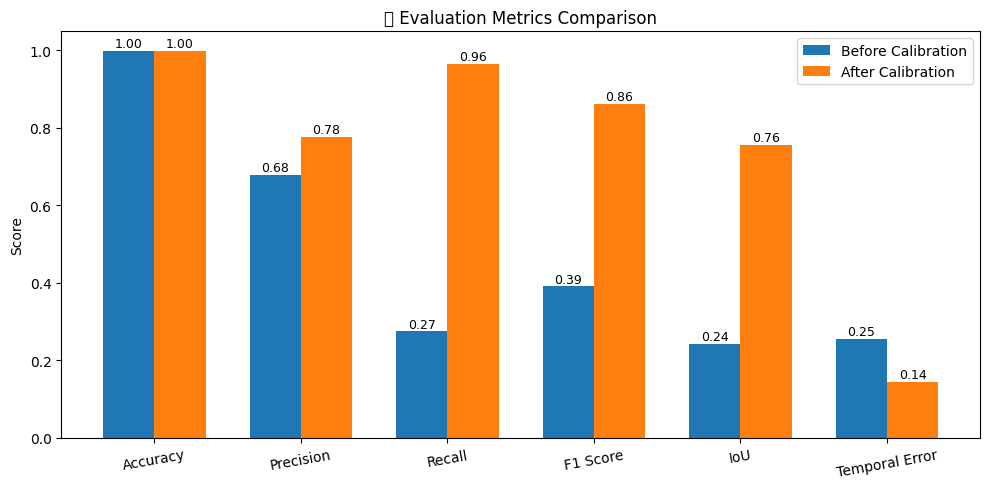

In [25]:

labels = list(metrics_before_vals.keys())
before_vals = [metrics_before_vals[k] for k in labels]
after_vals = [metrics_after_vals[k] for k in labels]

# Plotting code remains the same



import numpy as np
import matplotlib.pyplot as plt

labels = list(metrics_after_vals.keys())  # ['Accuracy', 'Precision', ...]
before_vals = [metrics_before_vals[k] for k in labels]
after_vals = [metrics_after_vals[k] for k in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
bars1 = ax.bar(x - width/2, before_vals, width, label='Before Calibration')
bars2 = ax.bar(x + width/2, after_vals, width, label='After Calibration')

ax.set_ylabel('Score')
ax.set_title('📊 Evaluation Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=10)
ax.legend()

# Bar labels: handle formatting for Temporal Error separately
for bar, val in zip(bars1, before_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f"{val:.2f}" if val <= 1 else f"{val:.0f}", ha='center', fontsize=9)

for bar, val in zip(bars2, after_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f"{val:.2f}" if val <= 1 else f"{val:.0f}", ha='center', fontsize=9)

plt.tight_layout()
plt.show()


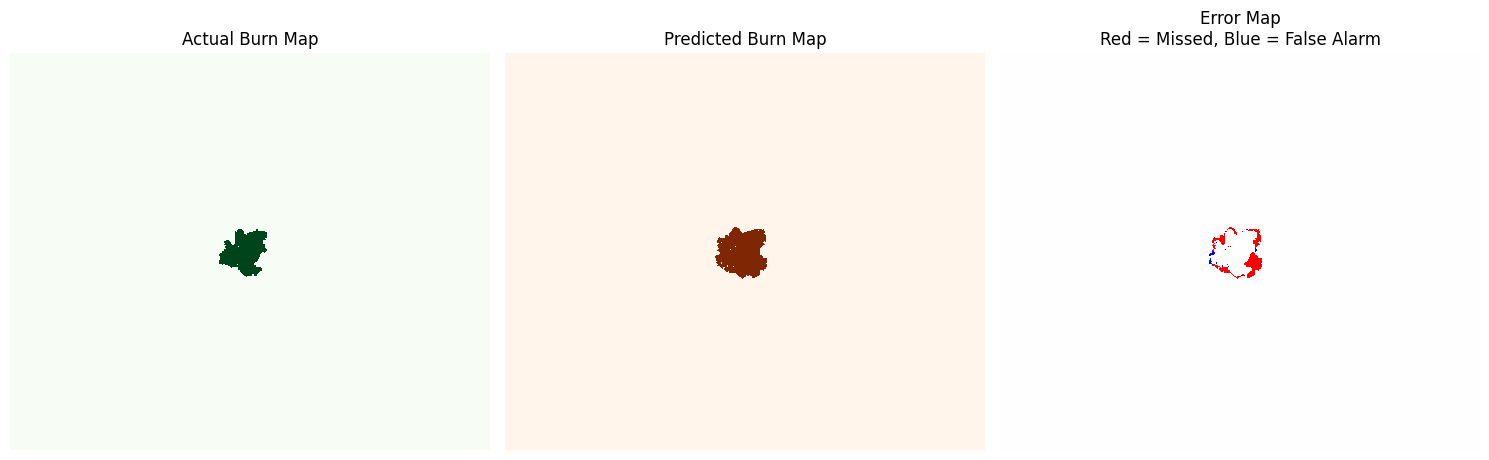

In [26]:
# @title Actual vs. Predicted vs. Error

import numpy as np
import matplotlib.pyplot as plt

# 🔄 Convert time series data into binary "burned at any time" maps
gt_burned = (ground_truth.sum(axis=0) > 0).astype(int)
pred_burned = (after_calibration.sum(axis=0) > 0).astype(int)

# 🔍 Error map: red = model missed fire (FN), blue = model false alarm (FP)
#   0 = correct, 1 = FP, -1 = FN
error_map = pred_burned - gt_burned

# 🎨 Plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(gt_burned, cmap='Greens', interpolation='nearest')
axs[0].set_title("Actual Burn Map")
axs[0].axis("off")

axs[1].imshow(pred_burned, cmap='Oranges', interpolation='nearest')
axs[1].set_title("Predicted Burn Map")
axs[1].axis("off")

axs[2].imshow(error_map, cmap='bwr', interpolation='nearest', vmin=-1, vmax=1)
axs[2].set_title("Error Map\nRed = Missed, Blue = False Alarm")
axs[2].axis("off")

plt.tight_layout()
plt.show()


/tmp/ipython-input-920363256.py:35: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.88])  # Leave space for title
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


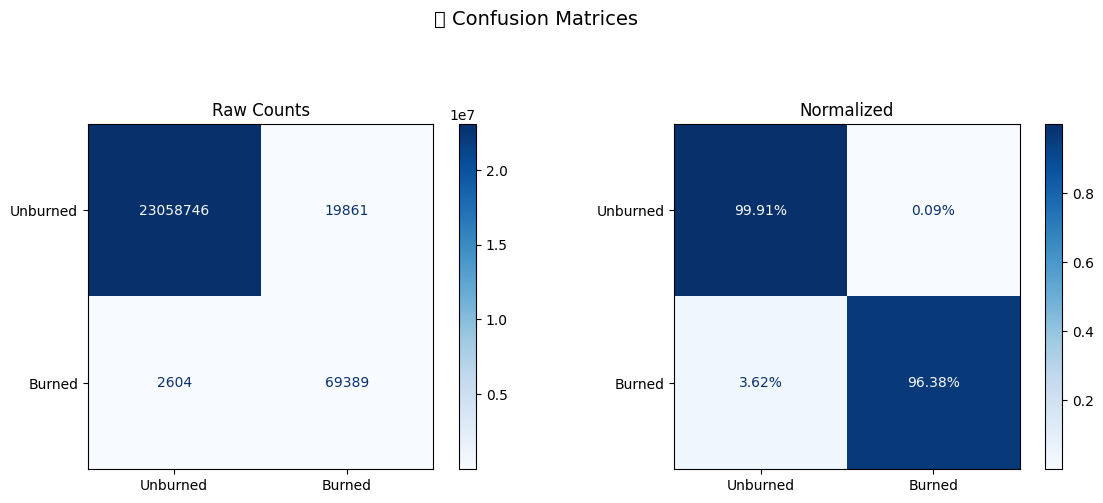

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_score, recall_score
)

# Flatten the predictions and targets
target_bin = (ground_truth > 0.5).astype(int).reshape(-1)
pred_bin = (after_calibration > 0.5).astype(int).reshape(-1)



# Confusion matrices
cm_raw = confusion_matrix(target_bin, pred_bin)
cm_norm = confusion_matrix(target_bin, pred_bin, normalize='true')

# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Slightly smaller
fig.suptitle(f"🔥 Confusion Matrices", fontsize=14)

disp_raw = ConfusionMatrixDisplay(confusion_matrix=cm_raw, display_labels=["Unburned", "Burned"])
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=["Unburned", "Burned"])

disp_raw.plot(ax=axes[0], cmap="Blues", values_format="d", colorbar=True)
axes[0].set_title("Raw Counts")
axes[0].set_xlabel("")
axes[0].set_ylabel("")

disp_norm.plot(ax=axes[1], cmap="Blues", values_format=".2%", colorbar=True)
axes[1].set_title("Normalized")
axes[1].set_xlabel("")
axes[1].set_ylabel("")

plt.tight_layout(rect=[0, 0.03, 1, 0.88])  # Leave space for title
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


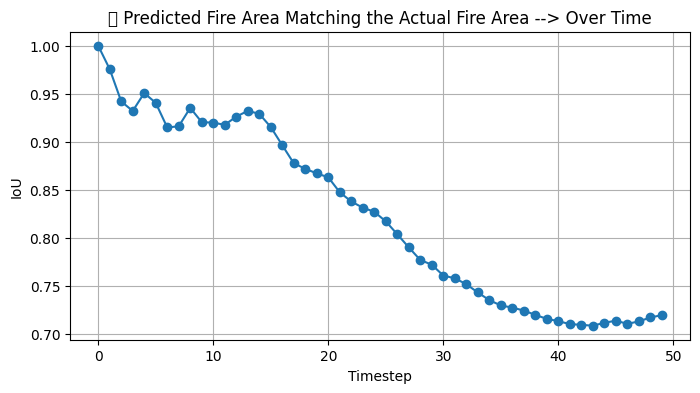

In [28]:
from sklearn.metrics import jaccard_score

timesteps = after_calibration.shape[0]
iou_per_timestep = []

for t in range(timesteps):
    pred_bin = (after_calibration[t] > 0.5).astype(int).reshape(-1)
    gt_bin = (ground_truth[t] > 0.5).astype(int).reshape(-1)
    iou = jaccard_score(gt_bin, pred_bin, zero_division=0)
    iou_per_timestep.append(iou)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(range(timesteps), iou_per_timestep, marker='o')
plt.title("📈 Predicted Fire Area Matching the Actual Fire Area --> Over Time")
plt.xlabel("Timestep")
plt.ylabel("IoU")
plt.grid(True)
plt.show()
